# Last 2 week confirmed cases in finland at each hospital districs

### Aim of this exercise is to create static map to show covid-19 cases of last tow weeks

Principles and help to this code is taken from: https://github.com/VuokkoH/koronavirus-avoindata

1. Read municipalities and hospital districs data and create polygons for health care districts
Population count of each municiplaties is also merged to data
    - Municipalities data: https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html
    - Health care districts data: https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat
    - Population of municipality: https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html
2. Read Covid-19 data and merge it to health care districts data
    - Covid-19 data: https://github.com/HS-Datadesk/koronavirus-avoindata
    - HS data non-updating interface, downloaded 3.12.2020
3. Create map

In [1]:
# Import packages
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import mapclassify

# 1. Read municipalities data and hospital districs data in 

In [2]:
# Read municipalities data in
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
municip = gpd.read_file(url)

# Check data
municip.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2020,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,kunta1000k.2,009,2020,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,kunta1000k.3,010,2020,Alavus,Alavus,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,kunta1000k.4,016,2020,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,kunta1000k.5,018,2020,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


In [3]:
# Rename  kunta column and select important columns
municip.rename(columns={"kunta":"code"}, inplace=True)
municip = municip[["code", "name", "geometry"]]

# Check data
municip.head()

,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


<AxesSubplot:>

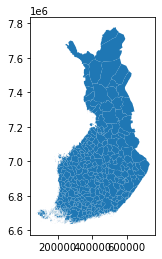

In [4]:
# Plot 'municip' map
municip.plot()

In [5]:
# Read Hospital district information data from excel
data = pd.read_excel(r"Data/Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)

# Chek data
data.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
0,NaN,NaN,NaN,NaN,NaN,NaN
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0


In [6]:
# Drop NaN row, data is also missing Åland municipalities
data.dropna(inplace=True)

In [7]:
# Rename columns from fin to eng
data.rename(columns={"kunta-\nkoodi":"code", "sairaanhoitopiiri":"healthCareDistrict"}, inplace=True)

# Use only useful columns
data = data[["code", "healthCareDistrict"]]

In [8]:
# Check data types of columns
data.dtypes

code                  float64
healthCareDistrict     object
dtype: object

In [9]:
# 'code' column type needs to modify to mach whit municip data (from float to character string)
data["code"] = data["code"].astype(int).astype('str')

# Add missing zeros in front of 'code'
data["code"] = data["code"].apply(lambda x: "00" + x if len(x)==1 else x)
data["code"] = data["code"].apply(lambda x: "0" + x if len(x)==2 else x)

# Check data
data.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


In [10]:
# Read population count of each municipalities
# Population is from 31.12.2018
url = "http://geo.stat.fi/geoserver/vaestoalue/wfs?request=GetFeature&typename=vaestoalue:kunta_vaki2018&outputformat=JSON"
pop = gpd.read_file(url)

# Select/ reneame columns
pop = pop[["kunta", "name", "vaesto", "geometry"]]
pop.rename(columns={"kunta": "code", "vaesto": "population"}, inplace=True)
# Check data
pop.head()

,code,name,population,geometry
0,005,Alajärvi,9700,"MULTIPOLYGON (((348733.187 6959704.551, 343298..."
1,009,Alavieska,2573,"MULTIPOLYGON (((370424.741 7104339.037, 360962..."
2,010,Alavus,11544,"MULTIPOLYGON (((317245.323 6922242.407, 310933..."
3,016,Asikkala,8149,"MULTIPOLYGON (((434407.880 6774122.311, 422536..."
4,018,Askola,4958,"MULTIPOLYGON (((423421.791 6704555.878, 420729..."


In [11]:
# After this data was published Valtimo and Nurmes was merged in 2020
if " Valtimo" in pop["name"].values:
    # Change Nurmes code and name to Valtimo
    pop.loc[pop["name"]=="Valtimo", "code"] = pop[pop["name"]=="Nurmes"].code.to_numpy()[0]
    pop.loc[pop["name"]=="Valtimo", "name"] = pop[pop["name"]=="Nurmes"].name.to_numpy()[0]
    
    # Merge geometries
    temp = pop.dissolve(by="code", aggfunc="sum")
    temp.reset_index(inplace=True)
    
    # Re-join
    pop = temp.merge(pop[["code", "name"]].drop_duplicates(), on="code", how="left")

In [12]:
# Merge population info to municipality data
municip = municip.merge(pop[["code", "name", "population"]], on="code")

# Merge also health care data to 'municip' data
municip = municip.merge(data, on="code", how="left")

In [13]:
municip

,code,name_x,geometry,name_y,population,healthCareDistrict
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6...",Alajärvi,9700,Etelä-Pohjanmaa
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7...",Alavieska,2573,Pohjois-Pohjanmaa
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6...",Alavus,11544,Etelä-Pohjanmaa
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6...",Asikkala,8149,Päijät-Häme
4,018,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6...",Askola,4958,HUS
...,...,...,...,...,...,...
305,977,Ylivieska,"POLYGON ((398010.991 7110887.267, 399696.069 7...",Ylivieska,15212,Pohjois-Pohjanmaa
306,980,Ylöjärvi,"POLYGON ((313738.511 6896936.100, 319421.316 6...",Ylöjärvi,32983,Pirkanmaa
307,981,Ypäjä,"POLYGON ((297451.456 6756204.328, 297931.884 6...",Ypäjä,2357,Kanta-Häme
308,989,Ähtäri,"POLYGON ((348733.187 6959704.551, 349457.337 6...",Ähtäri,5703,Etelä-Pohjanmaa


In [14]:
# Updata "Ahvenenmaa" as the health district for Åland municipalities (Åland district = null)
municip.loc[municip["healthCareDistrict"].isnull(), "healthCareDistrict"] = "Ahvenanmaa"

In [15]:
# Dissolve municip polygon geometries for each healt care districts
districts = municip.dissolve(by="healthCareDistrict", aggfunc="sum")
districts.reset_index(inplace=True)

districts.head()

,healthCareDistrict,geometry,population
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789
1,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756
2,Etelä-Pohjanmaa,"POLYGON ((249539.259 6894974.367, 244232.829 6...",194316
3,Etelä-Savo,"POLYGON ((596327.952 6823806.064, 596718.363 6...",100226
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418...",1667203


In [16]:
# Save the data so that it can be used in next exercise
districts.to_file("Data/healtCare.geojson", driver="GeoJSON", encoding="utf-8")

# 2. Read COVID-19 data

- There is now Health Care Districts, geometryes and population at the data frame. 
- Next covid data from last tow weeks is merged to districts data. 

In [17]:
# Read covid json data as a dict
with open('Data/v2.json') as json_data:
    data_dict = json.load(json_data)

In [18]:
# Check keys
data_dict.keys()

dict_keys(['confirmed', 'deaths', 'recovered'])

In [19]:
# There is also deaths and recovered but in this case we are interested in 'confirmed' cases
covid_conf = pd.DataFrame.from_dict(data_dict["confirmed"])

# check tail of the data
covid_conf.tail()

,id,date,healthCareDistrict,infectionSource,infectionSourceCountry
26417,Satakunta_2020-12-02T15:00:00.000Z_1,2020-12-02T15:00:00.000Z,Satakunta,None,None
26418,Varsinais-Suomi_2020-12-02T15:00:00.000Z_1,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None
26419,Varsinais-Suomi_2020-12-02T15:00:00.000Z_2,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None
26420,Varsinais-Suomi_2020-12-02T15:00:00.000Z_3,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None
26421,Varsinais-Suomi_2020-12-02T15:00:00.000Z_4,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None


In [20]:
# Separate month and day to own columns from date column
covid_conf["month"] = covid_conf["date"].str.slice(start=5, stop=7)
covid_conf["day"] = covid_conf["date"].str.slice(start=8, stop=10)

# Add month_day column by joining month and day columns and change type to int
covid_conf["month_day"] = (covid_conf["month"] + covid_conf["day"]).astype(int)

# Chek that columns look fine
covid_conf.tail()

,id,date,healthCareDistrict,infectionSource,infectionSourceCountry,month,day,month_day
26417,Satakunta_2020-12-02T15:00:00.000Z_1,2020-12-02T15:00:00.000Z,Satakunta,None,None,12,02,1202
26418,Varsinais-Suomi_2020-12-02T15:00:00.000Z_1,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None,12,02,1202
26419,Varsinais-Suomi_2020-12-02T15:00:00.000Z_2,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None,12,02,1202
26420,Varsinais-Suomi_2020-12-02T15:00:00.000Z_3,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None,12,02,1202
26421,Varsinais-Suomi_2020-12-02T15:00:00.000Z_4,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None,12,02,1202


In [21]:
# check that dtypes of columns are fine
covid_conf.dtypes

id                        object
date                      object
healthCareDistrict        object
infectionSource           object
infectionSourceCountry    object
month                     object
day                       object
month_day                  int64
dtype: object

In [22]:
# By using "month_day" column divide confirmed covid cases from last tow weeks (18.11 - 2.12.2020 in this case)
covid_tow_w = covid_conf.loc[covid_conf["month_day"]>=1118]

# Check that data looks right
covid_tow_w

,id,date,healthCareDistrict,infectionSource,infectionSourceCountry,month,day,month_day
20530,HUS_2020-11-18T15:00:00.000Z_1,2020-11-18T15:00:00.000Z,HUS,None,None,11,18,1118
20531,HUS_2020-11-18T15:00:00.000Z_2,2020-11-18T15:00:00.000Z,HUS,None,None,11,18,1118
20532,HUS_2020-11-18T15:00:00.000Z_3,2020-11-18T15:00:00.000Z,HUS,None,None,11,18,1118
20533,HUS_2020-11-18T15:00:00.000Z_4,2020-11-18T15:00:00.000Z,HUS,None,None,11,18,1118
20534,HUS_2020-11-18T15:00:00.000Z_5,2020-11-18T15:00:00.000Z,HUS,None,None,11,18,1118
...,...,...,...,...,...,...,...,...
26417,Satakunta_2020-12-02T15:00:00.000Z_1,2020-12-02T15:00:00.000Z,Satakunta,None,None,12,02,1202
26418,Varsinais-Suomi_2020-12-02T15:00:00.000Z_1,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None,12,02,1202
26419,Varsinais-Suomi_2020-12-02T15:00:00.000Z_2,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None,12,02,1202
26420,Varsinais-Suomi_2020-12-02T15:00:00.000Z_3,2020-12-02T15:00:00.000Z,Varsinais-Suomi,None,None,12,02,1202


In [23]:
# Join covid cases to districts whit "healthCareDistrict" as key
covid_regions = districts.merge(covid_tow_w, on="healthCareDistrict", how="left")

# check data
covid_regions

,healthCareDistrict,geometry,population,id,date,infectionSource,infectionSourceCountry,month,day,month_day
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789,Ahvenanmaa_2020-11-20T15:00:00.000Z_1,2020-11-20T15:00:00.000Z,None,None,11,20,1120
1,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789,Ahvenanmaa_2020-11-29T15:00:00.000Z_1,2020-11-29T15:00:00.000Z,None,None,11,29,1129
2,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756,Etelä-Karjala_2020-11-18T15:00:00.000Z_1,2020-11-18T15:00:00.000Z,None,None,11,18,1118
3,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756,Etelä-Karjala_2020-11-19T15:00:00.000Z_1,2020-11-19T15:00:00.000Z,None,None,11,19,1119
4,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756,Etelä-Karjala_2020-11-19T15:00:00.000Z_2,2020-11-19T15:00:00.000Z,None,None,11,19,1119
...,...,...,...,...,...,...,...,...,...,...
5887,Varsinais-Suomi,"MULTIPOLYGON (((258767.605 6632338.388, 258668...",481478,Varsinais-Suomi_2020-12-01T15:00:00.000Z_32,2020-12-01T15:00:00.000Z,None,None,12,01,1201
5888,Varsinais-Suomi,"MULTIPOLYGON (((258767.605 6632338.388, 258668...",481478,Varsinais-Suomi_2020-12-02T15:00:00.000Z_1,2020-12-02T15:00:00.000Z,None,None,12,02,1202
5889,Varsinais-Suomi,"MULTIPOLYGON (((258767.605 6632338.388, 258668...",481478,Varsinais-Suomi_2020-12-02T15:00:00.000Z_2,2020-12-02T15:00:00.000Z,None,None,12,02,1202
5890,Varsinais-Suomi,"MULTIPOLYGON (((258767.605 6632338.388, 258668...",481478,Varsinais-Suomi_2020-12-02T15:00:00.000Z_3,2020-12-02T15:00:00.000Z,None,None,12,02,1202


In [24]:
# Calculate confirmed cases per region based on covid_region data (counts how many cases there is at each district) 
count = covid_regions.groupby(by="healthCareDistrict").id.count()

# Rename column  
count.rename("confirmed_cases", inplace=True).sort_values(ascending=False)

healthCareDistrict
HUS                  3490
Pohjois-Pohjanmaa     448
Varsinais-Suomi       350
Pirkanmaa             350
Päijät-Häme           290
Keski-Suomi           157
Etelä-Pohjanmaa       111
Satakunta             109
Kymenlaakso           106
Pohjois-Karjala       103
Pohjois-Savo           80
Kanta-Häme             69
Etelä-Savo             56
Etelä-Karjala          39
Lappi                  32
Kainuu                 26
Keski-Pohjanmaa        25
Vaasa                  23
Länsi-Pohja            22
Itä-Savo                4
Ahvenanmaa              2
Name: confirmed_cases, dtype: int64

In [25]:
# Join conf cases to district poly
districts = districts.merge(count, left_on="healthCareDistrict", right_index=True)
districts.head()

,healthCareDistrict,geometry,population,confirmed_cases
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789,2
1,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756,39
2,Etelä-Pohjanmaa,"POLYGON ((249539.259 6894974.367, 244232.829 6...",194316,111
3,Etelä-Savo,"POLYGON ((596327.952 6823806.064, 596718.363 6...",100226,56
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418...",1667203,3490


# 3. Create static map

In [26]:
# Calculate the incidence number of each district, which mean conf.cases divided whit population of district multiplyed whit 100 000 (this is comonlu used in covid statics)
districts["incidence"] = round((districts["confirmed_cases"]/districts["population"])*100000).astype(int) # Round the numbers and set type to int


In [27]:
districts.head(23)

,healthCareDistrict,geometry,population,confirmed_cases,incidence
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789,2,7
1,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756,39,30
2,Etelä-Pohjanmaa,"POLYGON ((249539.259 6894974.367, 244232.829 6...",194316,111,57
3,Etelä-Savo,"POLYGON ((596327.952 6823806.064, 596718.363 6...",100226,56,56
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418...",1667203,3490,209
5,Itä-Savo,"POLYGON ((572240.425 6898837.522, 576521.513 6...",41060,4,10
6,Kainuu,"POLYGON ((606127.874 7081796.115, 603849.594 7...",73061,26,36
7,Kanta-Häme,"POLYGON ((393094.362 6756355.691, 394102.316 6...",171364,69,40
8,Keski-Pohjanmaa,"MULTIPOLYGON (((302835.219 7083897.220, 302801...",77689,25,32
9,Keski-Suomi,"POLYGON ((439110.805 6852598.036, 439300.113 6...",252676,157,62


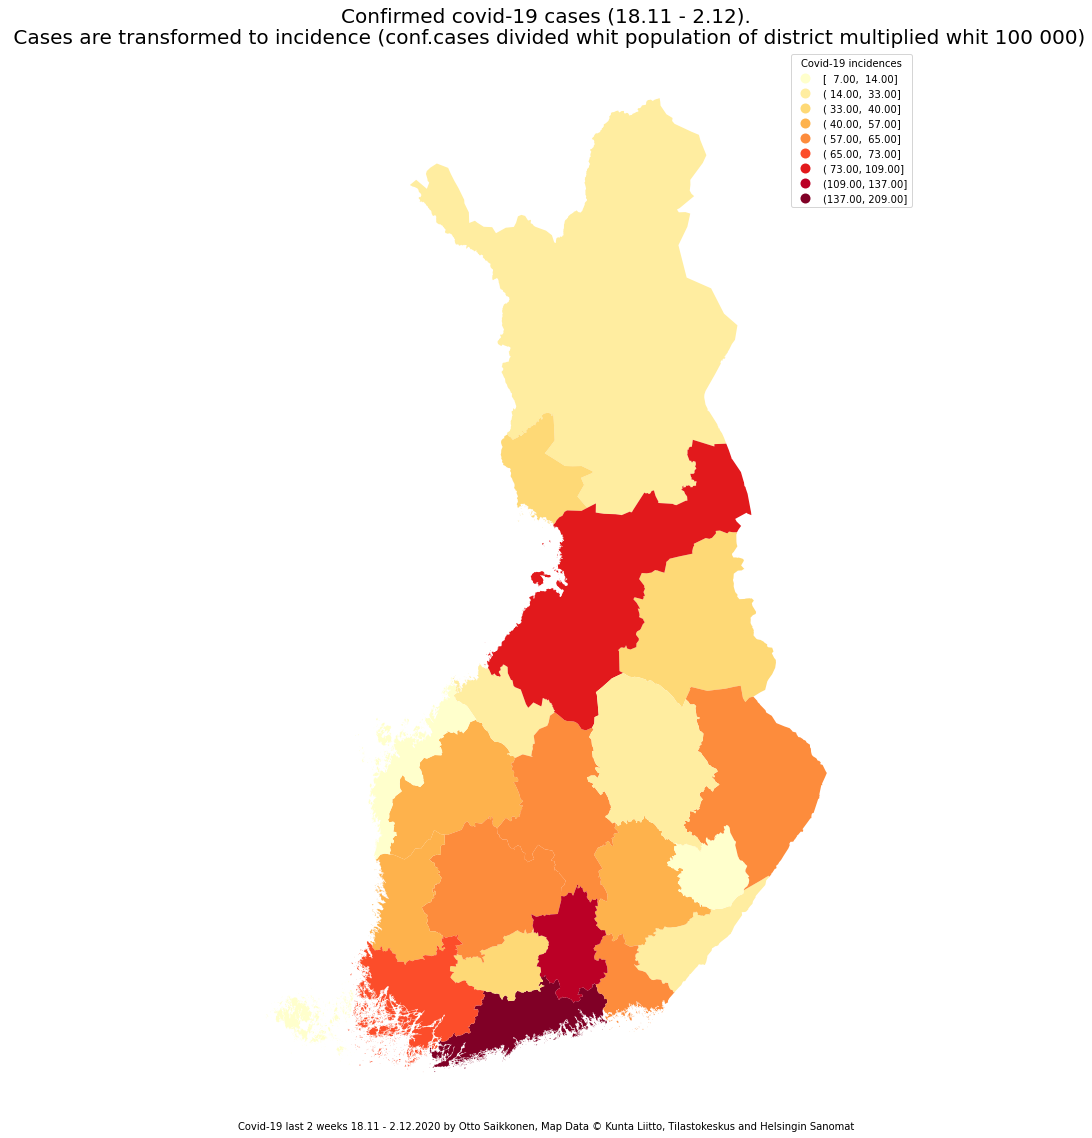

In [28]:
fig, ax = plt.subplots(figsize=(10,20))
districts.plot(ax=ax, 
               column="incidence",
               cmap="YlOrRd",
               scheme="naturalbreaks",
               k=9,
               legend=True
              )
# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.1,1))
ax.get_legend().set_title("Covid-19 incidences")

# Set title
ax.set_title("Confirmed covid-19 cases (18.11 - 2.12).\n Cases are transformed to incidence (conf.cases divided whit population of district multiplied whit 100 000)", fontsize=20)

# Add credits
left, width = .0, 2
bottom, height = .0, 2

ax.text(left, bottom, "Covid-19 last 2 weeks 18.11 - 2.12.2020 by Otto Saikkonen, Map Data © Kunta Liitto, Tilastokeskus and Helsingin Sanomat",
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

# Remove the empty white-space around the axes
plt.tight_layout()

# Remove frame
plt.axis("off")



outfp = "docs/Covid-19_2w.png"
plt.savefig(outfp, dpi=150)